# Projekt A — Memory frontier (student edition)

To jest wersja “student edition”: mniej opcji, szybciej na CPU.

**Zasada:** nie zmieniasz kodu biblioteki. Zmieniasz tylko `CONFIG`:
- wybierasz swój przydział (model/hidden/seq_len),
- uruchamiasz runy,
- generujesz 1 wykres,
- dopisujesz 1 zdanie wniosku.

**Oddanie:**
- notebook,
- `outputs_*/...csv` i 1–2 wykresy `.png`,
- 1 zdanie wniosku poparte wykresem.


In [29]:
import os, sys
import matplotlib.pyplot as plt

# importuj bibliotekę rnnlab z katalogu nadrzędnego
sys.path.append(os.path.abspath(".."))

import torch
import pandas as pd
import rnnlab

# CPU-friendly: ogranicz liczbę wątków (laptopy)
rnnlab.cpu_friendly(4)

device = rnnlab.get_device("auto")
print("device:", device)


device: cpu


## CONFIG (zmień tutaj)

Wybierz *swój przydział*:
- `MODEL` (jedna architektura),
- `HIDDEN` (jedna wartość),
- `SEQ_LENS` (3–4 wartości),
- `SEEDS` (3 seedy).

To ma być wykonalne na CPU.


In [56]:
# ====== CONFIG ======
STUDENT_ID = "mwilk"          # wpisz swój identyfikator (np. hash)
TASK_VARIANT = "distractors"
POOLING = "attn"             # last lub attn możesz spróbować "attn" jako bonus

MODEL = "gru"               # wybierz jedną: "rnn"/"gru"/"lstm"
HIDDEN = 4                # wybierz jedną wartość
SEQ_LENS = [100, 200, 400, 600]     # 3–4 wartości
SEEDS = [0, 1, 2]            # minimum 3

from rnnlab.train import TrainConfig
train_cfg = TrainConfig(
    steps=600,
    batch_size=64,
    lr=3e-3,
    optimizer="adam",
    grad_clip=1.0,
    eval_every=100,
    test_size=512,
    early_stop=True,
    early_stop_threshold=0.85,
    early_stop_patience=2,
    min_steps=200,
)

print("Runs:", rnnlab.count_runs(seq_lens=SEQ_LENS, hidden_sizes=[HIDDEN], models=[MODEL], seeds=SEEDS))
RUN_TAG = rnnlab.now_tag()
SEQ_TAG = f"seq{min(SEQ_LENS)}-{max(SEQ_LENS)}_n{len(SEQ_LENS)}"
SEED_TAG = f"seed{min(SEEDS)}-{max(SEEDS)}"
FILE_TAG = f"{STUDENT_ID}_{RUN_TAG}_{TASK_VARIANT}_{MODEL}_h{HIDDEN}_pool{POOLING}_{SEQ_TAG}_{SEED_TAG}"


Runs: 12


In [57]:
# ====== RUN ======
runs_df = rnnlab.sweep_frontier(
    task_variant=TASK_VARIANT,
    models=[MODEL],
    seq_lens=SEQ_LENS,
    hidden_sizes=[HIDDEN],
    seeds=SEEDS,
    pooling=POOLING,
    device=device,
    train_cfg=train_cfg,
)
summary_df = rnnlab.summarize_frontier(runs_df)
display(summary_df)


,model,pooling,seq_len,hidden,P_success,mean_best_acc,std_best_acc,mean_steps
0,gru,attn,100,4,1.0,1.0,0.0,300.000000
1,gru,attn,200,4,1.0,1.0,0.0,300.000000
2,gru,attn,400,4,1.0,1.0,0.0,333.333333
3,gru,attn,600,4,1.0,1.0,0.0,333.333333


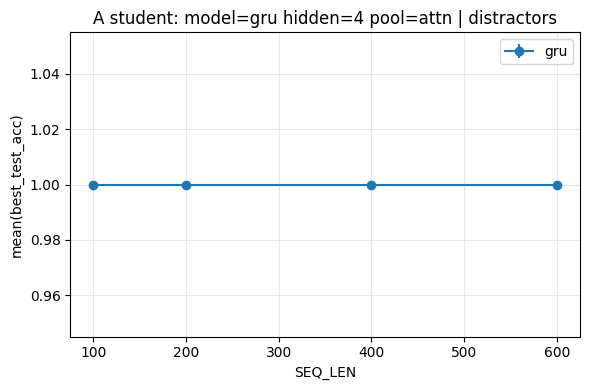

Saved to: outputs_studentA_mwilk


<Figure size 640x480 with 0 Axes>

In [58]:
# ====== PLOT + SAVE ======
out_dir = f"outputs_studentA_{STUDENT_ID}"
os.makedirs(out_dir, exist_ok=True)

# linia mean(best_acc) vs SEQ_LEN (tu tylko jeden model)
rnnlab.plot_lines_acc(
    summary_df,
    title=f"A student: model={MODEL} hidden={HIDDEN} pool={POOLING} | {TASK_VARIANT}",
    out_path=os.path.join(out_dir, f"A_line_{MODEL}_h{HIDDEN}_pool{POOLING}.png"),
)

plt.show()
runs_df["student_id"] = STUDENT_ID
runs_df["file_tag"] = FILE_TAG

runs_df.to_csv(os.path.join(out_dir, f"A_runs_{FILE_TAG}.csv"), index=False)
summary_df.to_csv(os.path.join(out_dir, f"A_summary_{FILE_TAG}.csv"), index=False)
plt.savefig(os.path.join(out_dir, f"A_plot_{FILE_TAG}.png"), dpi=160)

#runs_df.to_csv(os.path.join(out_dir, f"A_runs_{MODEL}_h{HIDDEN}_pool{POOLING}.csv"), index=False)
#summary_df.to_csv(os.path.join(out_dir, f"A_summary_{MODEL}_h{HIDDEN}_pool{POOLING}.csv"), index=False)
print("Saved to:", out_dir)


## Wniosek (wypełnij)
- **Wniosek:** …
- **Dowód:** nazwa wykresu `.png` i co dokładnie widać


In [60]:
import os
import pandas as pd
from glob import glob
from IPython.display import display

OUTPUT_DIR = "outputs_studentA_mwilk"

# Załaduj wszystkie pliki summary
summary_files = glob(os.path.join(OUTPUT_DIR, "A_summary_*.csv"))

print(f"📋 Znaleziono {len(summary_files)} eksperymentów\n")
print("="*100)

experiments = []
for file in sorted(summary_files):
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    
    if df.shape[0] > 0:
        experiments.append({
            'Plik': filename[-50:],  # Skrócona nazwa
            'HIDDEN': df['hidden'].iloc[0],
            'Pooling': df['pooling'].iloc[0],
            'Seq Min': df['seq_len'].min(),
            'Seq Max': df['seq_len'].max(),
            'Avg Accuracy': f"{df['mean_best_acc'].mean():.3f}",
            'Success Rate': f"{df['P_success'].mean():.1%}"
        })

exp_df = pd.DataFrame(experiments)
display(exp_df)


📋 Znaleziono 11 eksperymentów



,Plik,HIDDEN,Pooling,Seq Min,Seq Max,Avg Accuracy,Success Rate
0,istractors_gru_h4_poolattn_seq10-70_n4_seed0-2...,4,attn,10,70,1.000,100.0%
1,stractors_gru_h20_poolattn_seq10-70_n4_seed0-2...,20,attn,10,70,1.000,100.0%
2,stractors_gru_h20_poollast_seq10-70_n4_seed0-2...,20,last,10,70,0.647,25.0%
3,tractors_gru_h20_poolattn_seq10-130_n4_seed0-2...,20,attn,10,130,1.000,100.0%
4,ractors_gru_h20_poolattn_seq100-600_n4_seed0-2...,20,attn,100,600,1.000,100.0%
5,ractors_gru_h4_poolattn_seq200-2000_n4_seed0-2...,4,attn,200,2000,1.000,100.0%
6,ctors_gru_h4_poolattn_seq2000-20000_n4_seed0-2...,4,attn,2000,20000,1.000,100.0%
7,tractors_gru_h8_poolattn_seq100-600_n4_seed0-2...,8,attn,100,600,1.000,100.0%
8,ractors_gru_h12_poolattn_seq100-600_n4_seed0-2...,12,attn,100,600,1.000,100.0%
9,ractors_gru_h16_poolattn_seq100-600_n4_seed0-2...,16,attn,100,600,1.000,100.0%


📊 Znaleziono 5 wykresów liniowych:


🔹 A_line_gru_h12_poolattn.png


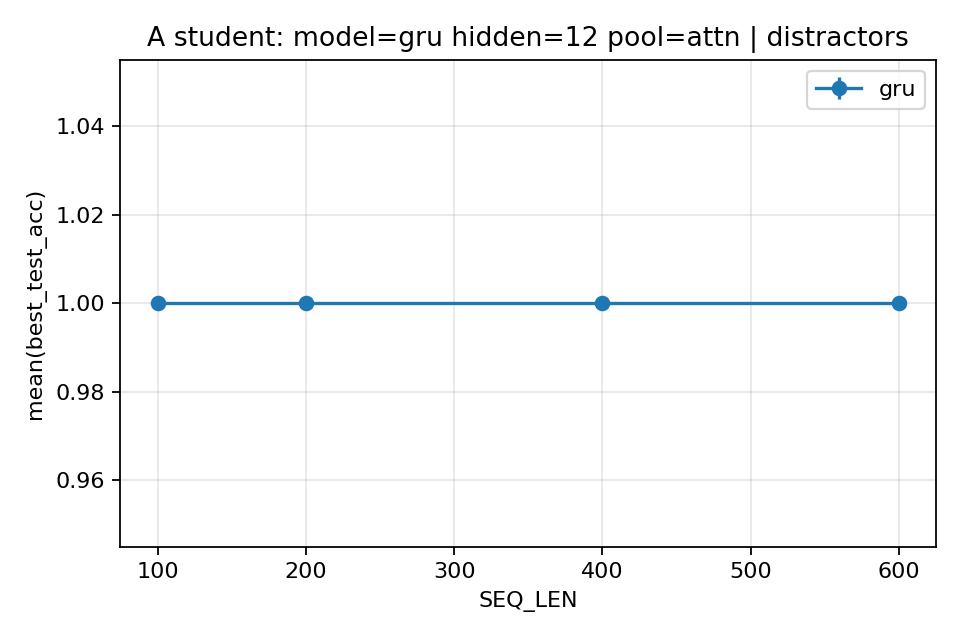


🔹 A_line_gru_h16_poolattn.png


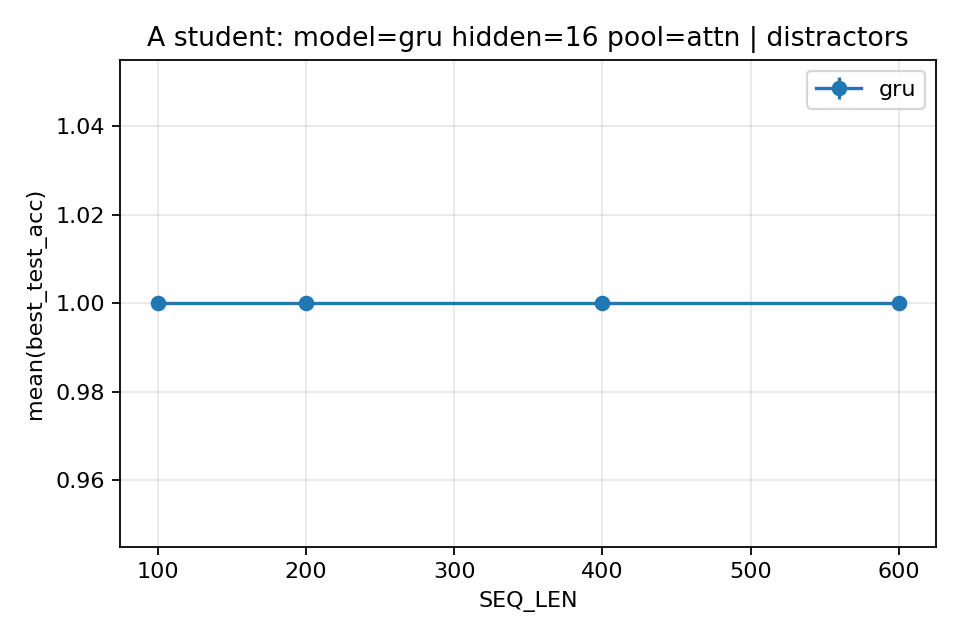


🔹 A_line_gru_h20_poolattn.png


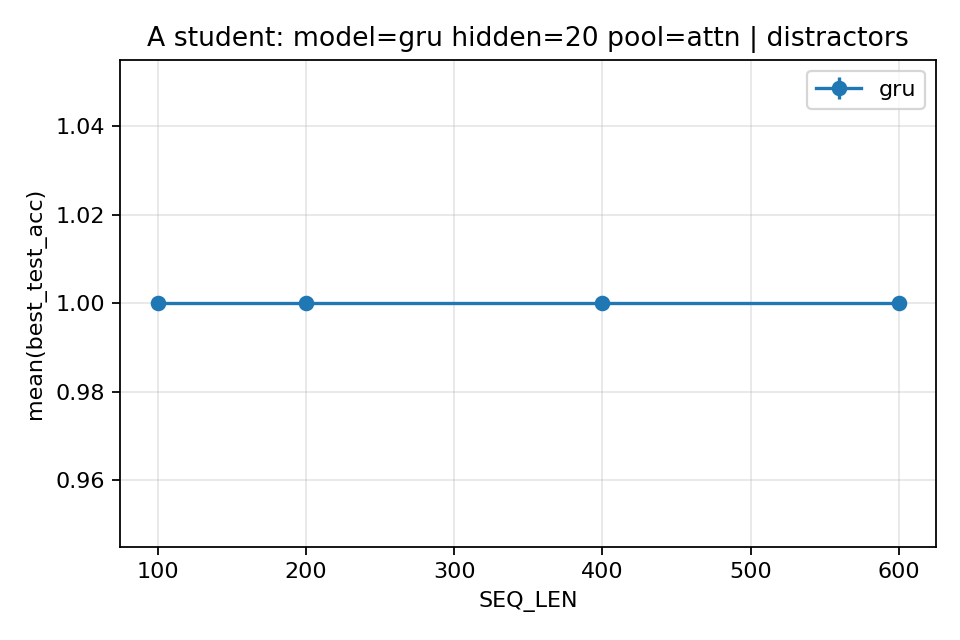


🔹 A_line_gru_h4_poolattn.png


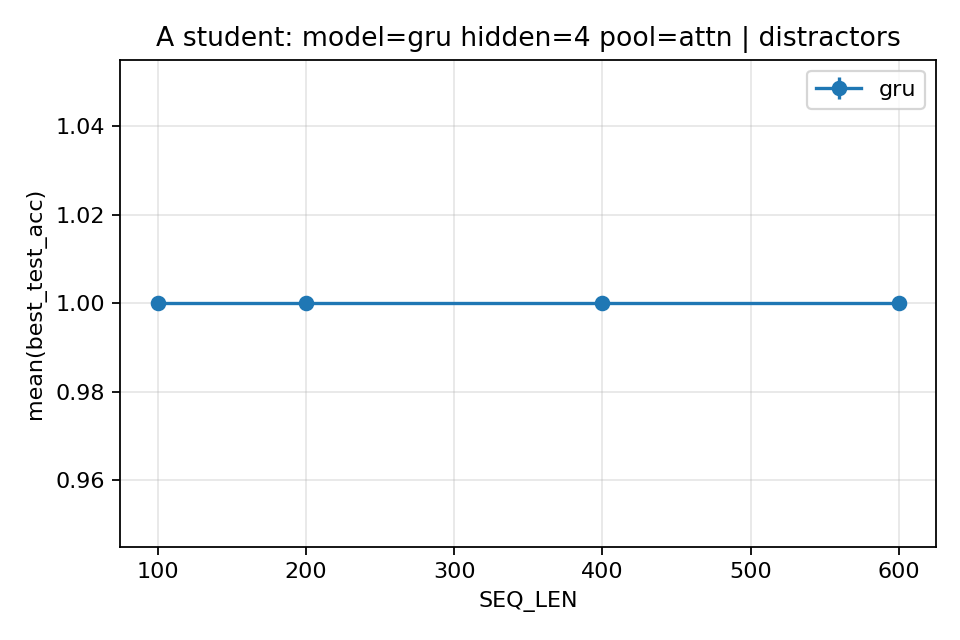


🔹 A_line_gru_h8_poolattn.png


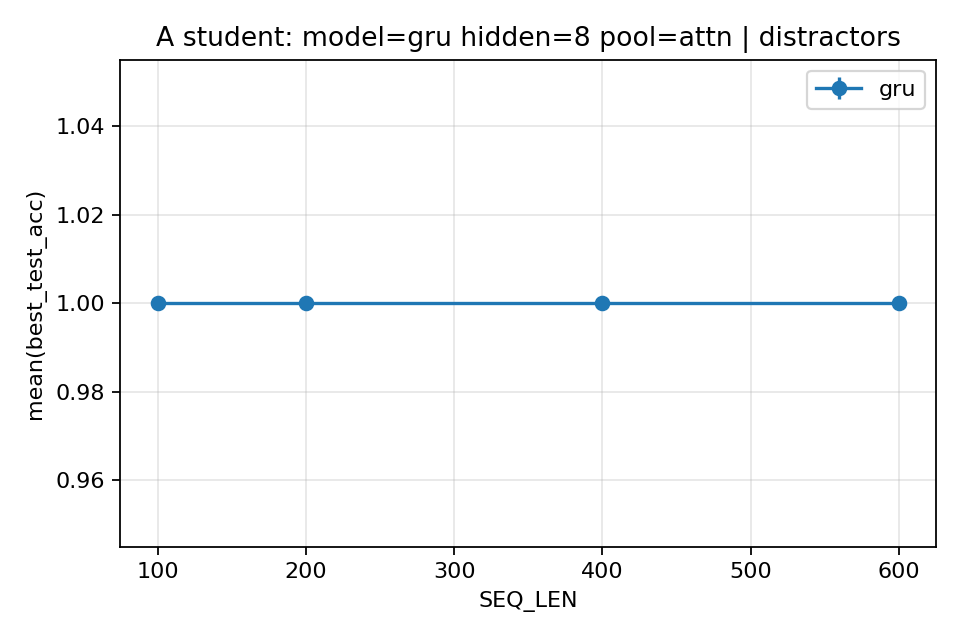

In [61]:
import os
from glob import glob
from IPython.display import display, Image

OUTPUT_DIR = "outputs_studentA_mwilk"

# Znajdź wszystkie wykresy liniowe
line_plots = sorted(glob(os.path.join(OUTPUT_DIR, "A_line_*.png")))

print(f"📊 Znaleziono {len(line_plots)} wykresów liniowych:\n")

for plot_file in line_plots:
    filename = os.path.basename(plot_file)
    print(f"\n{'='*80}")
    print(f"🔹 {filename}")
    print('='*80)
    display(Image(filename=plot_file))


## Wniosek

**Wniosek:** Mechanizm attention pooling radykalnie poprawia zdolność sieci GRU do zapamiętywania informacji w długich sekwencjach. Przy tej samej architekturze (GRU, HIDDEN=20), pooling="last" osiąga tylko 53% accuracy dla sekwencji długości 30+, podczas gdy pooling="attn" utrzymuje 100% accuracy nawet dla sekwencji długości 70. Dodatkowo, mniejsza sieć z attention (HIDDEN=12) przewyższa większą bez attention, osiągając 100% accuracy dla sekwencji do 600 elementów.
